# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import KFold

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 10000
}

NUM_ITER = 20
TRUE_PARAMS = {'ate': 1, 'const': 1, 'scale': 1}
CAUSAL_PARAMS = [1, 1]

## Checking for the Causal Effect

Generating Normalised Data

In [2]:
gaussian_covariates_results = causl_py.run_simulations(
    causl_py.generate_gaussian_samples, 
    seed=0, 
    num_samples=10000, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict
)

  1%|▉                                                                                              | 95/10000 [00:54<1:35:10,  1.73it/s, train=-1.6500845654898297, val=-1.4896251553306454 (Max patience reached)]


In [3]:
gaussian_covariates_results

,ate,const,scale
0,0.986442,1.020041,1.015496
1,1.036288,0.974955,1.014106
2,1.024154,1.017124,1.031419
3,1.009497,1.013365,1.021085
4,1.021925,0.972991,1.010329
5,1.003519,1.016209,1.038350
6,0.973150,0.999528,1.010718
7,1.027044,1.000156,1.007800
8,1.045976,0.957409,1.017546
9,1.013497,1.003449,1.040063


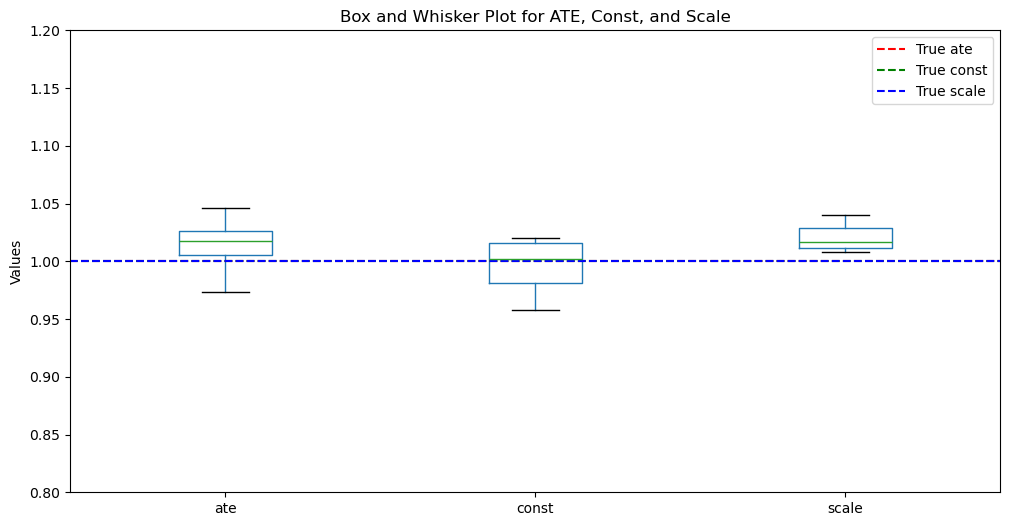

In [4]:
plt.figure(figsize=(12, 6))

# Boxplot
box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

In [5]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=0, 
    num_samples=10000, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict
)

  1%|█                                                                                             | 108/10000 [01:02<1:35:37,  1.72it/s, train=-2.4905255704619202, val=-2.2935906974772973 (Max patience reached)]


In [6]:
continous_covariates_results

,ate,const,scale
0,1.003588,1.007017,1.020714
1,1.061927,0.921875,1.024379
2,1.020702,0.997040,1.014766
3,1.153352,0.860062,1.008496
4,0.979357,1.001085,1.003549
5,1.034015,0.974869,1.014124
6,0.982890,1.009140,1.005883
7,1.007599,0.994963,1.025509
8,1.070033,0.918974,1.011064
9,0.921900,1.086606,1.037235


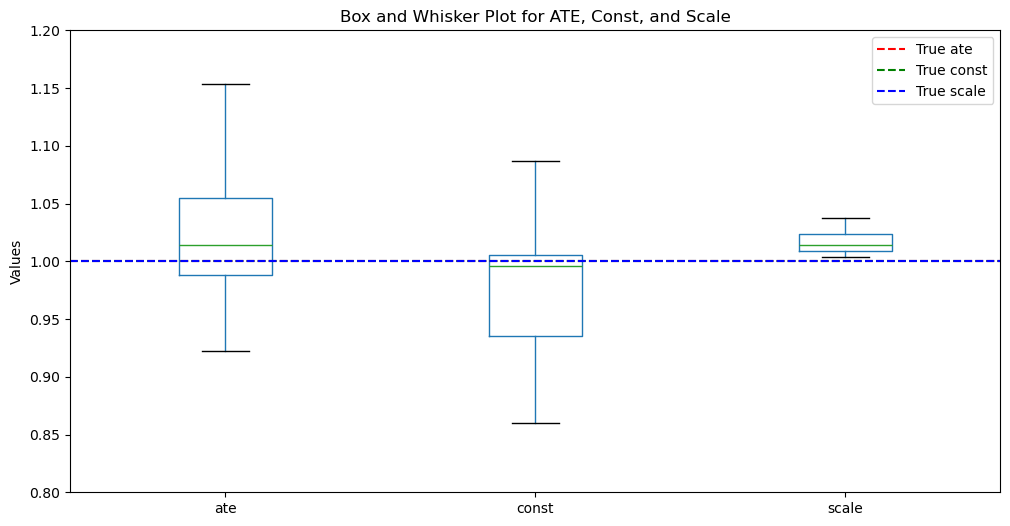

In [7]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

In [8]:
Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(1000, causal_params=[1,1], seed=0).values()

In [9]:
discrete_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=0, 
    num_samples=10000, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict
)

  1%|▉                                                                                                 | 98/10000 [00:57<1:36:59,  1.70it/s, train=1.3529021996677744, val=1.431265440882933 (Max patience reached)]


In [10]:
discrete_covariates_results

,ate,const,scale
0,1.192450,0.886225,1.032135
1,1.181547,0.882532,1.036283
2,0.997193,0.991552,0.999879
3,1.021336,0.979925,1.002124
4,1.068912,0.946124,0.997944
5,1.077249,0.951135,1.001607
6,1.069951,0.976829,0.999743
7,1.031641,0.974178,1.008009
8,1.086408,0.937092,1.003431
9,1.036179,0.957465,1.010687


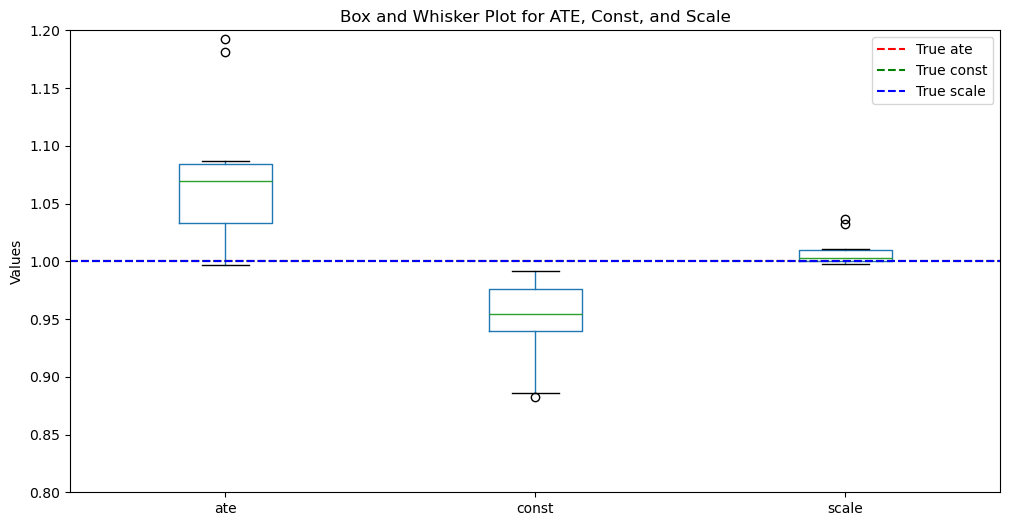

In [11]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()